In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
epochs = 30
noise = True
loss_ratio = 0.5

In [3]:
def noised(x, mean=0., std=1e-3):
    return torch.clip(x + torch.randn_like(x) * std + mean, 0., 1.)

In [4]:
# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(256, z_dim)
        self.fc_logvar = nn.Linear(256, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decode(z)
        return x_recon, z_mean, z_logvar

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def decode(self, z):
        return self.decoder(z)

In [5]:
# 训练VAE
def train_vae(train_loader, valid_loader, vae, optimizer, criterion, epochs):
    train_losses = []
    valid_losses = []
    reconn_errors = []
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        reconn_error = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            if noise:
                data = noised(data)
            recon_batch, mu, logvar = vae(data)
            loss, reconn_loss = criterion(recon_batch, data, mu, logvar)
            reconn_error += reconn_loss.item()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))
        reconn_errors.append(reconn_error / len(train_loader.dataset))
        
        valid_loss = validate(valid_loader, vae, criterion)
        valid_losses.append(valid_loss / len(valid_loader.dataset))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Valid Loss: {valid_losses[-1]:.6f}")
    return train_losses, valid_losses, reconn_errors

In [11]:
# 验证VAE
def validate(valid_loader, vae, criterion):
    vae.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, _ in valid_loader:
            recon_batch, mu, logvar = vae(data)
            valid_loss += criterion(recon_batch, data, mu, logvar)[0].item()
    return valid_loss


In [7]:
# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + loss_ratio * KLD, BCE

In [8]:
# 生成图片
def generate_images(vae, z_dim):
    vae.eval()
    if z_dim == 1:
        z = torch.linspace(-5, 5, 256).reshape(-1, 1)
    elif z_dim == 2:
        x = torch.linspace(-5, 5, 16)
        y = torch.linspace(-5, 5, 16)
        z = torch.cartesian_prod(x, y)
    else:
        raise ValueError("z_dim must be 1 or 2")
    x = vae.decode(z).detach().numpy()
    image = np.zeros((28 * 16, 28 * 16))
    for i in range(16):
        for j in range(16):
            image[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = x[i * 16 + j, 0].reshape(28, 28)
    plt.imshow(image, cmap='gray')

In [9]:
# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [13]:
# 将隐层向量z维度设置为1
z_dim = 1
vae = VAE(z_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = vae_loss

ratio = [0.1, 0.5, 1, 2, 10]
for i in range(5):
    loss_ratio = ratio[i]
    train_losses, valid_losses, reconn_error = train_vae(train_loader, valid_loader, vae, optimizer, criterion, epochs)
    plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss ratio='+str(ratio[i]))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30, Train Loss: 199.368611, Valid Loss: 177.742222
Epoch 2/30, Train Loss: 176.171410, Valid Loss: 173.339099


KeyboardInterrupt: 

Epoch 1/30, Train Loss: 196.268013, Valid Loss: 179.435751
Epoch 2/30, Train Loss: 176.623281, Valid Loss: 171.724618
Epoch 3/30, Train Loss: 171.657560, Valid Loss: 168.687351
Epoch 4/30, Train Loss: 168.717539, Valid Loss: 167.291314
Epoch 5/30, Train Loss: 166.929440, Valid Loss: 164.381145
Epoch 6/30, Train Loss: 165.431201, Valid Loss: 163.318026
Epoch 7/30, Train Loss: 164.582143, Valid Loss: 162.557675
Epoch 8/30, Train Loss: 163.655273, Valid Loss: 162.050272
Epoch 9/30, Train Loss: 162.890520, Valid Loss: 161.073494
Epoch 10/30, Train Loss: 162.355583, Valid Loss: 160.589666
Epoch 11/30, Train Loss: 161.751929, Valid Loss: 160.357172
Epoch 12/30, Train Loss: 161.157304, Valid Loss: 160.137314
Epoch 13/30, Train Loss: 160.882228, Valid Loss: 159.385233
Epoch 14/30, Train Loss: 160.253456, Valid Loss: 158.631356
Epoch 15/30, Train Loss: 159.885721, Valid Loss: 159.107432
Epoch 16/30, Train Loss: 159.599720, Valid Loss: 158.293928
Epoch 17/30, Train Loss: 159.292896, Valid Loss: 

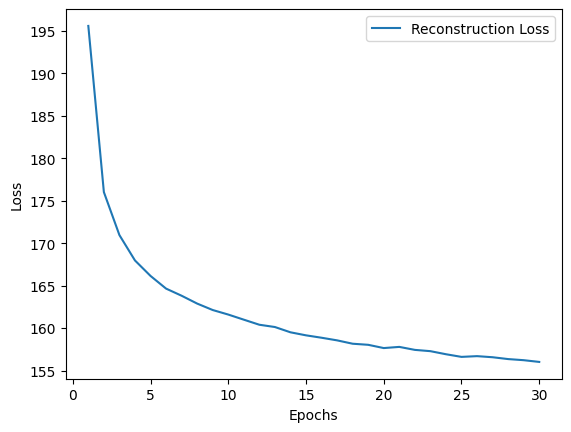

In [14]:
# 将隐层向量z维度设置为1
z_dim = 1
vae = VAE(z_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = vae_loss

train_losses, valid_losses, reconn_error = train_vae(train_loader, valid_loader, vae, optimizer, criterion, epochs)

plt.plot(range(1, epochs+1), reconn_error, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generating images for z dimension = 1:


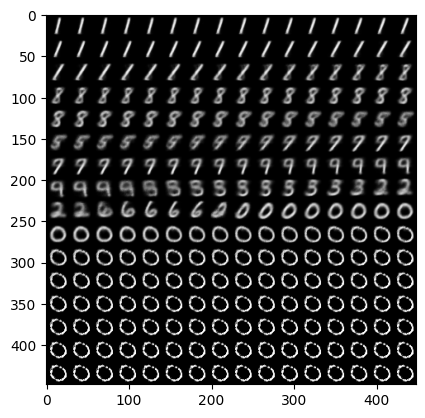

In [15]:
z_dim = 1
print("Generating images for z dimension = 1:")
generate_images(vae, z_dim)

Epoch 1/30, Train Loss: 180.624430, Valid Loss: 155.793338
Epoch 2/30, Train Loss: 153.885568, Valid Loss: 149.163608
Epoch 3/30, Train Loss: 149.317500, Valid Loss: 146.421953
Epoch 4/30, Train Loss: 146.828819, Valid Loss: 144.301631
Epoch 5/30, Train Loss: 145.050432, Valid Loss: 142.960240
Epoch 6/30, Train Loss: 143.774142, Valid Loss: 141.695564
Epoch 7/30, Train Loss: 142.655586, Valid Loss: 141.674941
Epoch 8/30, Train Loss: 141.704395, Valid Loss: 140.684172
Epoch 9/30, Train Loss: 140.886681, Valid Loss: 140.120677
Epoch 10/30, Train Loss: 140.266798, Valid Loss: 139.604560
Epoch 11/30, Train Loss: 139.566533, Valid Loss: 138.995245
Epoch 12/30, Train Loss: 139.038110, Valid Loss: 138.547731
Epoch 13/30, Train Loss: 138.565530, Valid Loss: 138.764920
Epoch 14/30, Train Loss: 138.124699, Valid Loss: 138.241537
Epoch 15/30, Train Loss: 137.685652, Valid Loss: 137.641187
Epoch 16/30, Train Loss: 137.286307, Valid Loss: 137.759855
Epoch 17/30, Train Loss: 136.929328, Valid Loss: 

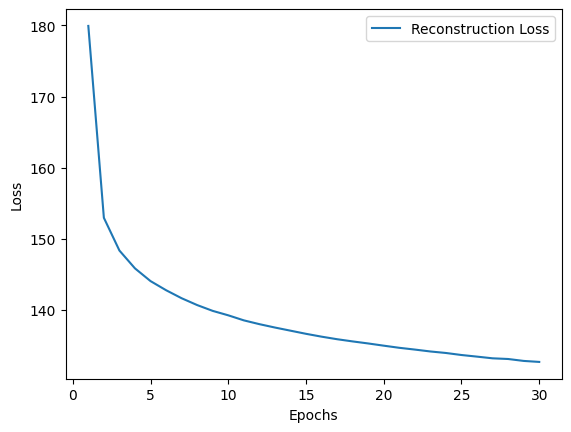

In [16]:
# 将隐层向量z维度设置为2
z_dim = 2
vae_2 = VAE(z_dim)
optimizer = optim.Adam(vae_2.parameters(), lr=1e-3)
criterion = vae_loss

train_losses, valid_losses, reconn_error = train_vae(train_loader, valid_loader, vae_2, optimizer, criterion, epochs)

# plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
# plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss')
plt.plot(range(1, epochs+1), reconn_error, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generating images for z dimension = 2:


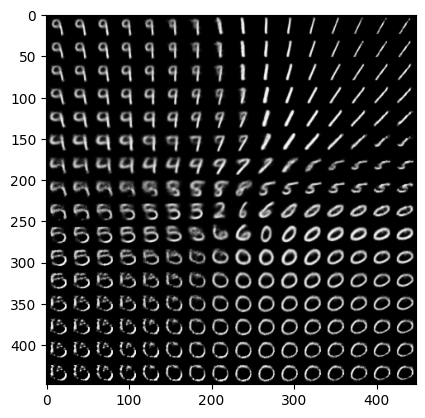

In [17]:
z_dim = 2
print("Generating images for z dimension = 2:")
generate_images(vae_2, z_dim)